In [45]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib as mpl

In [2]:
con = sqlite3.connect('data/core.muri2.2.denorm.db')

In [67]:
gh13_domain_features = pd.read_sql(r"""
    SELECT * FROM feature_x_cazy_minimal_domain
    JOIN feature_to_opf USING (feature_id)
    WHERE (
        domain_id LIKE 'GH13\_%' ESCAPE '\'
        OR domain_id IS 'GH13'
        )
       AND score > 50
""", con=con).sort_values('feature_id')

In [68]:
# One Opf (Opf05857) has two GH13 domains
two_gh13_domain_features = gh13_domain_features[gh13_domain_features.feature_id.duplicated(keep=False)]
two_gh13_domain_features

,feature_id,domain_id,score,domain_start,domain_stop,opf_id
566,Amulumruptor_caecigallinarius_01351,GH13_37,192.9,1197,1491,Opf05857
565,Amulumruptor_caecigallinarius_01351,GH13_19,376.8,176,565,Opf05857
376,GCA_002633305_00961,GH13_37,190.4,1197,1491,Opf05857
375,GCA_002633305_00961,GH13_19,376.8,176,565,Opf05857
797,GCA_009775355_01974,GH13_37,195.3,1017,1310,Opf05857
796,GCA_009775355_01974,GH13_19,375.4,180,568,Opf05857
838,GCA_009775505_00500,GH13_19,375.6,176,565,Opf05857
839,GCA_009775505_00500,GH13_37,191.6,1093,1386,Opf05857
890,GCA_902383915_01523,GH13_19,372.1,176,565,Opf05857
891,GCA_902383915_01523,GH13_37,193.4,1201,1494,Opf05857


In [69]:
# Almost all Opf05857 have both domains (except for two minor examples)
gh13_domain_features[(gh13_domain_features.opf_id == 'Opf05857') & (~gh13_domain_features.feature_id.isin(two_gh13_domain_features.feature_id))]

,feature_id,domain_id,score,domain_start,domain_stop,opf_id
80,H1_00376,GH13_19,378.8,176,565,Opf05857


/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:301: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mesh = ax.pcolormesh(self.plot_data, vmin=self.vmin, vmax=self.vmax,


domain_id,GH13,GH13_1,GH13_10,GH13_13,GH13_14,GH13_19,GH13_28,GH13_36,GH13_37,GH13_38,GH13_5,GH13_6,GH13_7,GH13_8
opf_id,,,,,,,,,,,,,,
Opf00581,0,0,0,0,0,0,0,0,0,0,0,0,0,130
Opf00668,0,0,0,0,0,0,0,0,0,136,0,0,0,0
Opf00838,0,0,0,113,1,0,0,0,0,0,0,0,0,0
Opf00965,93,0,1,0,0,0,0,0,0,0,0,0,0,0
Opf01163,0,0,0,0,0,0,102,0,0,0,0,0,0,0
Opf01338,67,0,0,0,0,0,0,0,0,0,0,0,0,0
Opf01765,47,0,0,0,0,0,0,0,0,0,0,0,0,0
Opf01860,0,0,0,0,0,0,0,0,43,0,0,0,0,0
Opf01909,36,0,0,0,0,0,0,0,0,0,0,0,0,0


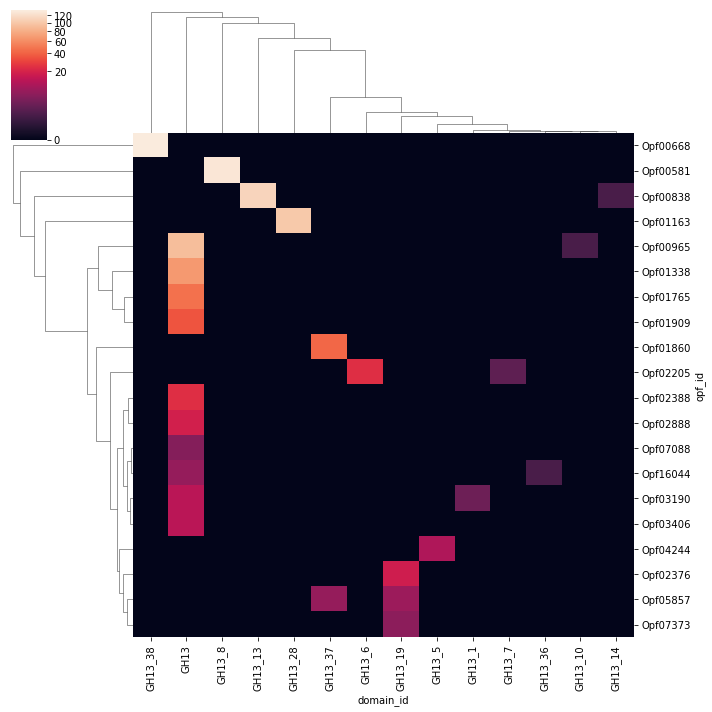

In [115]:
# GH13 domains and OPFs match very nicely.
opf_to_gh13_subfamily_feature_counts = gh13_domain_features.groupby(['opf_id', 'domain_id']).apply(len).sort_index()

sns.clustermap(
    opf_to_gh13_subfamily_feature_counts.unstack(fill_value=0),
    norm=mpl.colors.PowerNorm(1/3),
    yticklabels=1,
)

opf_to_gh13_subfamily_feature_counts.unstack(fill_value=0)

In [122]:
starch_domain_features

,opf_id,feature_id,domain_id,score,domain_start,domain_stop
1344,Opf01088,Amulumruptor_caecigallinarius_00051,GH31,420.0,218.0,662.0
777,Opf00668,Amulumruptor_caecigallinarius_00066,GH13_38,556.3,30.0,396.0
1980,Opf10188,Amulumruptor_caecigallinarius_00094,GH31,407.6,361.0,796.0
274,Opf01163,Amulumruptor_caecigallinarius_00337,GH13_28,125.2,39.0,329.0
138,Opf00490,Amulumruptor_caecigallinarius_00371,GH57,170.6,5.0,337.0
...,...,...,...,...,...,...
1495,Opf16044,Unclassified_Muribaculaceae_DSM_108610_01974,GH13_36,226.8,51.0,411.0
1165,Opf02888,Unclassified_Muribaculaceae_DSM_108610_02517,GH13,167.8,43.0,331.0
273,Opf00490,Unclassified_Muribaculaceae_DSM_108610_02573,GH57,212.0,5.0,322.0
912,Opf00668,Unclassified_Muribaculaceae_DSM_108610_02765,GH13_38,566.3,31.0,396.0


In [126]:
starch_domain_features

In [ ]:
# Pull all examples of any OPF with even one member matching a GH13 domain

starch_domain_features = (
    pd.read_sql(r"""
        SELECT *
        FROM (
            SELECT DISTINCT opf_id
            FROM starch_active_gh_domain
            JOIN feature_x_cazy_minimal_domain USING (domain_id)
            JOIN feature_to_opf USING (feature_id)
            WHERE score > 50
        )
        LEFT JOIN feature_to_opf USING (opf_id)
        LEFT JOIN feature_x_cazy_minimal_domain USING (feature_id)
        WHERE (score > 50 AND domain_id IN starch_active_gh_domain)
           OR domain_id IS NULL
    """, con=con)
    .sort_values('feature_id')
    .dropna(subset=['opf_id'])
    .assign(domain_id=lambda x: x.domain_id.fillna('no_gh_domain'))
)

In [127]:
# One Opf (Opf05857) has two GH13 domains
two_starch_domain_features = starch_domain_features[starch_domain_features.feature_id.duplicated(keep=False)]
two_starch_domain_features

,opf_id,feature_id,domain_id,score,domain_start,domain_stop
1952,Opf05857,Amulumruptor_caecigallinarius_01351,GH13_37,192.9,1197.0,1491.0
1951,Opf05857,Amulumruptor_caecigallinarius_01351,GH13_19,376.8,176.0,565.0
1953,Opf05857,GCA_002633305_00961,GH13_19,376.8,176.0,565.0
1954,Opf05857,GCA_002633305_00961,GH13_37,190.4,1197.0,1491.0
1996,Opf05953,GCA_003979105_00419,GH119,141.7,60.0,398.0
1995,Opf05953,GCA_003979105_00419,GH119,67.3,429.0,657.0
1997,Opf05953,GCA_004102785_02308,GH119,67.1,429.0,657.0
1998,Opf05953,GCA_004102785_02308,GH119,140.4,60.0,398.0
2000,Opf05953,GCA_009774955_00093,GH119,139.1,60.0,398.0
1999,Opf05953,GCA_009774955_00093,GH119,67.8,430.0,657.0


/Users/byronsmith/anaconda3/envs/compbio/lib/python3.8/site-packages/seaborn/matrix.py:301: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  mesh = ax.pcolormesh(self.plot_data, vmin=self.vmin, vmax=self.vmax,


domain_id,GH119,GH13,GH13_1,GH13_10,GH13_13,GH13_14,GH13_19,GH13_28,GH13_36,GH13_37,GH13_38,GH13_5,GH13_6,GH13_7,GH13_8,GH31,GH57,GH77,GH97,no_gh_domain
opf_id,,,,,,,,,,,,,,,,,,,,
Opf00042,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,193,1
Opf00307,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,138,0,0
Opf00490,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,0,0,0
Opf00581,0,0,0,0,0,0,0,0,0,0,0,0,0,0,130,0,0,0,0,2
Opf00668,0,0,0,0,0,0,0,0,0,0,136,0,0,0,0,0,0,0,0,0
Opf00838,0,0,0,0,113,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Opf00965,0,93,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Opf01080,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,91,0
Opf01088,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,95,0,0,0,2


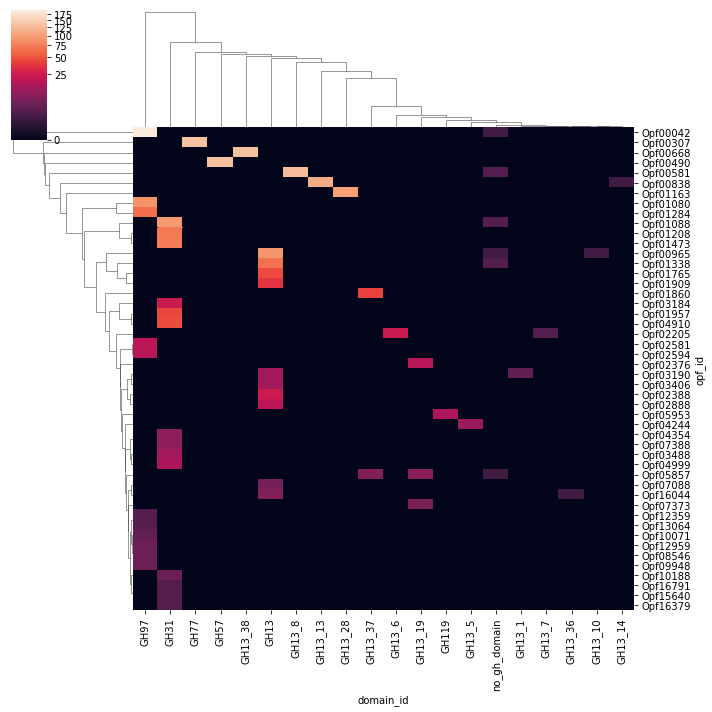

In [128]:
# GH13 domains and OPFs match very nicely.
opf_to_starch_subfamily_feature_counts = starch_domain_features.groupby(['opf_id', 'domain_id'], dropna=False).apply(len).sort_index()

sns.clustermap(
    opf_to_starch_subfamily_feature_counts.unstack(fill_value=0),
    norm=mpl.colors.PowerNorm(1/3),
    yticklabels=1,
)

opf_to_starch_subfamily_feature_counts.unstack(fill_value=0)